# Accessing data in a DataSet

After a measurement is completed all the acquired data and metadata around it is accessible via a `DataSet` object. This notebook presents the useful methods and properties of the `DataSet` object which enable convenient access to the data, parameters information, and more. For general overview of the `DataSet` class, refer to [DataSet class walkthrough](DataSet-class-walkthrough.ipynb).

## Preparation: a DataSet from a dummy Measurement

In order to obtain a `DataSet` object, we are going to run a `Measurement` storing some dummy data (see notebook on [Performing measurements using qcodes parameters and dataset](Performing-measurements-using-qcodes-parameters-and-dataset.ipynb) notebook for more details).

In [1]:
import tempfile
import os

import numpy as np

import qcodes
from qcodes import initialise_or_create_database_at, \
    load_or_create_experiment, Measurement, Parameter, \
    Station
from qcodes.dataset.plotting import plot_dataset

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : /home/runner/.qcodes/logs/command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


Qcodes Logfile : /home/runner/.qcodes/logs/211123-3412-qcodes.log


In [2]:
db_path = os.path.join(tempfile.gettempdir(), 'data_access_example.db')
initialise_or_create_database_at(db_path)

exp = load_or_create_experiment(experiment_name='greco', sample_name='draco')

0it [00:00, ?it/s]

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v1 -> v2:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v1 -> v2: 100%|██████████| 1/1 [00:00<00:00, 281.06it/s]

0it [00:00, ?it/s]

Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]

Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]

Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v4 -> v5:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v4 -> v5: 100%|██████████| 1/1 [00:00<00:00, 871.27it/s]

0it [00:00, ?it/s]

Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]

Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v6 -> v7:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v6 -> v7: 100%|██████████| 1/1 [00:00<00:00, 485.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v7 -> v8:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v7 -> v8: 100%|██████████| 1/1 [00:00<00:00, 821.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v8 -> v9:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v8 -> v9: 100%|██████████| 1/1 [00:00<00:00, 1305.82it/s]

In [3]:
x = Parameter(name='x', label='Voltage', unit='V',
              set_cmd=None, get_cmd=None)
t = Parameter(name='t', label='Time', unit='s',
              set_cmd=None, get_cmd=None)
y = Parameter(name='y', label='Voltage', unit='V',
              set_cmd=None, get_cmd=None)
y2 = Parameter(name='y2', label='Current', unit='A',
               set_cmd=None, get_cmd=None)
q = Parameter(name='q', label='Qredibility', unit='$',
               set_cmd=None, get_cmd=None)

In [4]:
meas = Measurement(exp=exp, name='fresco')

meas.register_parameter(x)
meas.register_parameter(t)
meas.register_parameter(y, setpoints=(x, t))
meas.register_parameter(y2, setpoints=(x, t))
meas.register_parameter(q)  # a standalone parameter

x_vals = np.linspace(-4, 5, 50)
t_vals = np.linspace(-500, 1500, 25)

with meas.run() as datasaver:
    for xv in x_vals:
        for tv in t_vals:
            yv = np.sin(2*np.pi*xv)*np.cos(2*np.pi*0.001*tv) + 0.001*tv
            y2v = np.sin(2*np.pi*xv)*np.cos(2*np.pi*0.001*tv + 0.5*np.pi) - 0.001*tv
            datasaver.add_result((x, xv), (t, tv), (y, yv), (y2, y2v))
        q_val = np.max(yv) - np.min(y2v)  # a meaningless value
        datasaver.add_result((q, q_val))

dataset = datasaver.dataset

Starting experimental run with id: 1. 


For the sake of demonstrating what kind of data we've produced, let's use `plot_dataset` to make some default plots of the data.

([<AxesSubplot:title={'center':'Run #1, Experiment greco (draco)'}, xlabel='Voltage (V)', ylabel='Time (ks)'>,
  <AxesSubplot:title={'center':'Run #1, Experiment greco (draco)'}, xlabel='Voltage (V)', ylabel='Time (ks)'>],
  <matplotlib.colorbar.Colorbar at 0x7fc168484bd0>])

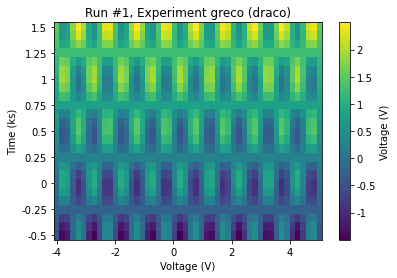

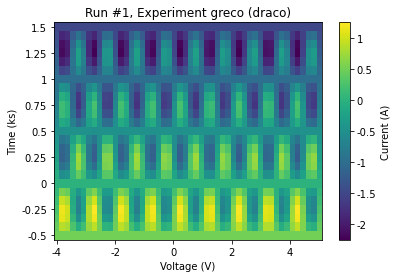

In [5]:
plot_dataset(dataset)

## DataSet indentification

Before we dive into what's in the `DataSet`, let's briefly note how a `DataSet` is identified.

In [6]:
dataset.captured_run_id

1

In [7]:
dataset.exp_name

'greco'

In [8]:
dataset.sample_name

'draco'

In [9]:
dataset.name

'fresco'

## Parameters in the DataSet

In this section we are getting information about the parameters stored in the given `DataSet`.

> Why is that important? Let's jump into *data*!

As it turns out, just "arrays of numbers" are not enough to reason about a given `DataSet`. Even comping up with a reasonable deafult plot, which is what `plot_dataset` does, requires information on `DataSet`'s parameters. In this notebook, we first have a detailed look at what is stored about parameters and how to work with this information. After that, we will cover data access methods.

### Run description

Every dataset comes with a "description" (aka "run description"):

In [10]:
dataset.description

RunDescriber(InterDependencies_(dependencies={ParamSpecBase('y', 'numeric', 'Voltage', 'V'): (ParamSpecBase('x', 'numeric', 'Voltage', 'V'), ParamSpecBase('t', 'numeric', 'Time', 's')), ParamSpecBase('y2', 'numeric', 'Current', 'A'): (ParamSpecBase('x', 'numeric', 'Voltage', 'V'), ParamSpecBase('t', 'numeric', 'Time', 's'))}, inferences={}, standalones=frozenset({ParamSpecBase('q', 'numeric', 'Qredibility', '$')})), Shapes: None)

The description, an instance of `RunDescriber` object, is intended to describe the details of a dataset. In the future releases of QCoDeS it will likely be expanded. At the moment, it only contains an `InterDependencies_` object under its `interdeps` attribute - which stores all the information about the parameters of the `DataSet`.

Let's look into this `InterDependencies_` object.

### Interdependencies

`Interdependencies_` object inside the run description contains information about all the parameters that are stored in the `DataSet`. Subsections below explain how the individual information about the parameters as well as their relationships are captured in the `Interdependencies_` object.

In [11]:
interdeps = dataset.description.interdeps
interdeps

InterDependencies_(dependencies={ParamSpecBase('y', 'numeric', 'Voltage', 'V'): (ParamSpecBase('x', 'numeric', 'Voltage', 'V'), ParamSpecBase('t', 'numeric', 'Time', 's')), ParamSpecBase('y2', 'numeric', 'Current', 'A'): (ParamSpecBase('x', 'numeric', 'Voltage', 'V'), ParamSpecBase('t', 'numeric', 'Time', 's'))}, inferences={}, standalones=frozenset({ParamSpecBase('q', 'numeric', 'Qredibility', '$')}))

#### Dependencies, inferences, standalones

Information about every parameter is stored in the form of `ParamSpecBase` objects, and the releationship between parameters is captured via `dependencies`, `inferences`, and `standalones` attributes.

For example, the dataset that we are inspecting contains no inferences, and one standalone parameter `q`, and two dependent parameters `y` and `y2`, which both depend on independent `x` and `t` parameters:

In [12]:
interdeps.inferences

{}

In [13]:
interdeps.standalones

frozenset({ParamSpecBase('q', 'numeric', 'Qredibility', '$')})

In [14]:
interdeps.dependencies

{ParamSpecBase('y', 'numeric', 'Voltage', 'V'): (ParamSpecBase('x', 'numeric', 'Voltage', 'V'),
  ParamSpecBase('t', 'numeric', 'Time', 's')),
 ParamSpecBase('y2', 'numeric', 'Current', 'A'): (ParamSpecBase('x', 'numeric', 'Voltage', 'V'),
  ParamSpecBase('t', 'numeric', 'Time', 's'))}

`dependencies` is a dictionary of `ParamSpecBase` objects. The keys are dependent parameters (those which depend on other parameters), and the corresponding values in the dictionary are tuples of independent parameters that the dependent parameter in the key depends on. Coloquially, each key-value pair of the `dependencies` dictionary is sometimes referred to as "parameter tree".

`inferences` follows the same structure as `dependencies`.

`standalones` is a set - an unordered collection of `ParamSpecBase` objects representing "standalone" parameters, the ones which do not depend on other parameters, and no other parameter depends on them.

#### ParamSpecBase objects

`ParamSpecBase` object contains all the necessary information about a given parameter, for example, its `name` and `unit`:

In [15]:
ps = list(interdeps.dependencies.keys())[0]
print(f'Parameter {ps.name!r} is in {ps.unit!r}')

Parameter 'y' is in 'V'


`paramspecs` property returns a tuple of `ParamSpecBase`s for all the parameters contained in the `Interdependencies_` object:

In [16]:
interdeps.paramspecs

(ParamSpecBase('y', 'numeric', 'Voltage', 'V'),
 ParamSpecBase('x', 'numeric', 'Voltage', 'V'),
 ParamSpecBase('t', 'numeric', 'Time', 's'),
 ParamSpecBase('y2', 'numeric', 'Current', 'A'),
 ParamSpecBase('q', 'numeric', 'Qredibility', '$'))

Here's a trivial example of iterating through dependent parameters of the `Interdependencies_` object and extracting information about them from the `ParamSpecBase` objects:

In [17]:
for d in interdeps.dependencies.keys():
    print(f'Parameter {d.name!r} ({d.label}, {d.unit}) depends on:')
    for i in interdeps.dependencies[d]:
        print(f'- {i.name!r} ({i.label}, {i.unit})')

Parameter 'y' (Voltage, V) depends on:
- 'x' (Voltage, V)
- 't' (Time, s)
Parameter 'y2' (Current, A) depends on:
- 'x' (Voltage, V)
- 't' (Time, s)


#### Other useful methods and properties

`Interdependencies_` object has a few useful properties and methods which make it easy to work it and with other `Interdependencies_` and `ParamSpecBase` objects.

For example, `non_dependencies` returns a tuple of all dependent parameters together with standalone parameters:

In [18]:
interdeps.non_dependencies

(ParamSpecBase('q', 'numeric', 'Qredibility', '$'),
 ParamSpecBase('y', 'numeric', 'Voltage', 'V'),
 ParamSpecBase('y2', 'numeric', 'Current', 'A'))

`what_depends_on` method allows to find what parameters depend on a given parameter:

In [19]:
t_ps = interdeps.paramspecs[2]
t_deps = interdeps.what_depends_on(t_ps)

print(f'Following parameters depend on {t_ps.name!r} ({t_ps.label}, {t_ps.unit}):')
for t_dep in t_deps:
    print(f'- {t_dep.name!r} ({t_dep.label}, {t_dep.unit})')

Following parameters depend on 't' (Time, s):
- 'y' (Voltage, V)
- 'y2' (Current, A)


### Shortcuts to important parameters

For the frequently needed groups of parameters, `DataSet` object itself provides convenient methods and properties.

For example, use `dependent_parameters` property to get only dependent parameters of a given `DataSet`:

In [20]:
dataset.dependent_parameters

(ParamSpecBase('y', 'numeric', 'Voltage', 'V'),
 ParamSpecBase('y2', 'numeric', 'Current', 'A'))

This is equivalent to:

In [21]:
tuple(dataset.description.interdeps.dependencies.keys())

(ParamSpecBase('y', 'numeric', 'Voltage', 'V'),
 ParamSpecBase('y2', 'numeric', 'Current', 'A'))

### Note on inferences

Inferences between parameters is a feature that has not been used yet within QCoDeS. The initial concepts around `DataSet` included it in order to link parameters that are not directly dependent on each other as "dependencies" are. It is very likely that "inferences" will be eventually deprecated and removed.

### Note on ParamSpec's

> `ParamSpec`s originate from QCoDeS versions prior to `0.2.0` and for now are kept for backwards compatibility. `ParamSpec`s are completely superseded by `InterDependencies_`/`ParamSpecBase` bundle and will likely be deprecated in future versions of QCoDeS together with the `DataSet` methods/properties that return `ParamSpec`s objects.

In addition to the `Interdependencies_` object, `DataSet` also holds `ParamSpec` objects (not to be confused with `ParamSpecBase` objects from above). Similar to `Interdependencies_` object, the `ParamSpec` objects hold information about parameters and their interdependencies but in a different way: for a given parameter, `ParamSpec` object itself contains information on names of parameters that it depends on, while for the `InterDependencies_`/`ParamSpecBase`s this information is stored only in the `InterDependencies_` object.

`DataSet` exposes `paramspecs` property and `get_parameters()` method, both of which return `ParamSpec` objects of all the parameters of the dataset, and are not recommended for use:

In [22]:
dataset.paramspecs

{'x': ParamSpec('x', 'numeric', 'Voltage', 'V', inferred_from=[], depends_on=[]),
 't': ParamSpec('t', 'numeric', 'Time', 's', inferred_from=[], depends_on=[]),
 'y': ParamSpec('y', 'numeric', 'Voltage', 'V', inferred_from=[], depends_on=['x', 't']),
 'y2': ParamSpec('y2', 'numeric', 'Current', 'A', inferred_from=[], depends_on=['x', 't']),
 'q': ParamSpec('q', 'numeric', 'Qredibility', '$', inferred_from=[], depends_on=[])}

In [23]:
dataset.get_parameters()

[ParamSpec('x', 'numeric', 'Voltage', 'V', inferred_from=[], depends_on=[]),
 ParamSpec('t', 'numeric', 'Time', 's', inferred_from=[], depends_on=[]),
 ParamSpec('y', 'numeric', 'Voltage', 'V', inferred_from=[], depends_on=['x', 't']),
 ParamSpec('y2', 'numeric', 'Current', 'A', inferred_from=[], depends_on=['x', 't']),
 ParamSpec('q', 'numeric', 'Qredibility', '$', inferred_from=[], depends_on=[])]

In [24]:
dataset.parameters

'x,t,y,y2,q'

To give an example of what it takes to work with `ParamSpec` objects as opposed to `Interdependencies_` object, here's a function that one needs to write in order to find standalone `ParamSpec`s from a given list of `ParamSpec`s:

In [25]:
def get_standalone_parameters(paramspecs):
    all_independents = set(spec.name
                           for spec in paramspecs
                           if len(spec.depends_on_) == 0)
    used_independents = set(d for spec in paramspecs for d in spec.depends_on_)
    standalones = all_independents.difference(used_independents)
    return tuple(ps for ps in paramspecs if ps.name in standalones)

all_parameters = dataset.get_parameters()
standalone_parameters = get_standalone_parameters(all_parameters)
standalone_parameters

(ParamSpec('q', 'numeric', 'Qredibility', '$', inferred_from=[], depends_on=[]),)

## Getting data from DataSet

In this section methods for retrieving the actual data from the `DataSet` are discussed.

### `get_parameter_data` - the powerhorse

`DataSet` provides one main method of accessing data - `get_parameter_data`. It returns data for groups of dependent-parameter-and-its-independent-parameters in a form of a nested dictionary of `numpy` arrays:

In [26]:
dataset.get_parameter_data()

{'q': {'q': array([3.        , 2.08558738, 2.259722  , 3.31510822, 3.99537911,
         3.49071755, 2.40188947, 2.02507209, 2.80884137, 3.82017225,
         3.85514276, 2.87212284, 2.04133215, 2.3517716 , 3.43388374,
         3.99948622, 3.375267  , 2.30431745, 2.06153158, 2.93592978,
         3.88659931, 3.78183148, 2.74634542, 2.01281822, 2.4544651 ,
         3.5455349 , 3.98718178, 3.25365458, 2.21816852, 2.11340069,
         3.06407022, 3.93846842, 3.69568255, 2.624733  , 2.00051378,
         2.56611626, 3.6482284 , 3.95866785, 3.12787716, 2.14485724,
         2.17982775, 3.19115863, 3.97492791, 3.59811053, 2.50928245,
         2.00462089, 2.68489178, 3.740278  , 3.91441262, 3.        ])},
 'y': {'y': array([-0.5       , -0.41666667, -0.33333333, ...,  1.33333333,
          1.41666667,  1.5       ]),
  'x': array([-4., -4., -4., ...,  5.,  5.,  5.]),
  't': array([-500.        , -416.66666667, -333.33333333, ..., 1333.33333333,
         1416.66666667, 1500.        ])},
 'y2': {'y2'

#### Avoid excessive calls to loading data

Note that this call actually reads the data of the `DataSet` and in case of a `DataSet` with a lot of data can take noticable amount of time. Hence, it is recommended to limit the number of times the same data gets loaded in order to speed up the user's code.

#### Loading data of selected parameters

Sometimes data only for a particular parameter or parameters needs to be loaded. For example, let's assume that after inspecting the `InterDependencies_` object from `dataset.description.interdeps`, we concluded that we want to load data of the `q` parameter and the `y2` parameter. In order to do that, we just pass the names of these parameters, or their `ParamSpecBase`s to `get_parameter_data` call:

In [27]:
q_param_spec = list(interdeps.standalones)[0]
q_param_spec

ParamSpecBase('q', 'numeric', 'Qredibility', '$')

In [28]:
y2_param_spec = interdeps.non_dependencies[-1]
y2_param_spec

ParamSpecBase('y2', 'numeric', 'Current', 'A')

In [29]:
dataset.get_parameter_data(q_param_spec, y2_param_spec)

{'q': {'q': array([3.        , 2.08558738, 2.259722  , 3.31510822, 3.99537911,
         3.49071755, 2.40188947, 2.02507209, 2.80884137, 3.82017225,
         3.85514276, 2.87212284, 2.04133215, 2.3517716 , 3.43388374,
         3.99948622, 3.375267  , 2.30431745, 2.06153158, 2.93592978,
         3.88659931, 3.78183148, 2.74634542, 2.01281822, 2.4544651 ,
         3.5455349 , 3.98718178, 3.25365458, 2.21816852, 2.11340069,
         3.06407022, 3.93846842, 3.69568255, 2.624733  , 2.00051378,
         2.56611626, 3.6482284 , 3.95866785, 3.12787716, 2.14485724,
         2.17982775, 3.19115863, 3.97492791, 3.59811053, 2.50928245,
         2.00462089, 2.68489178, 3.740278  , 3.91441262, 3.        ])},
 'y2': {'y2': array([ 0.5       ,  0.41666667,  0.33333333, ..., -1.33333333,
         -1.41666667, -1.5       ]),
  'x': array([-4., -4., -4., ...,  5.,  5.,  5.]),
  't': array([-500.        , -416.66666667, -333.33333333, ..., 1333.33333333,
         1416.66666667, 1500.        ])}}

### `to_pandas_dataframe_dict` and `to_pandas_dataframe` - for `pandas` fans

`DataSet` provides two methods for accessing data with `pandas` - `to_pandas_dataframe` and  `to_pandas_dataframe_dict`. The method `to_pandas_dataframe_dict` returns data for groups of dependent-parameter-and-its-independent-parameters in a form of a dictionary of `pandas.DataFrame` s, while `to_pandas_dataframe` returns a concatendated `pandas.DataFrame` for groups of dependent-parameter-and-its-independent-parameters:

In [30]:
df_dict = dataset.to_pandas_dataframe_dict()

# For the sake of making this article more readable,
# we will print the contents of the `dfs` dictionary
# manually by calling `.head()` on each of the DataFrames
for parameter_name, df in df_dict.items():
    print(f"DataFrame for parameter {parameter_name}")
    print("-----------------------------")
    print(f"{df.head()!r}")
    print("")

DataFrame for parameter q
-----------------------------
          q
0  3.000000
1  2.085587
2  2.259722
3  3.315108
4  3.995379

DataFrame for parameter y
-----------------------------
                         y
x    t                    
-4.0 -500.000000 -0.500000
     -416.666667 -0.416667
     -333.333333 -0.333333
     -250.000000 -0.250000
     -166.666667 -0.166667

DataFrame for parameter y2
-----------------------------
                        y2
x    t                    
-4.0 -500.000000  0.500000
     -416.666667  0.416667
     -333.333333  0.333333
     -250.000000  0.250000
     -166.666667  0.166667



Alternativly to concatinate the DataSet data into a single pandas Dataframe run the following:

In [31]:
df = dataset.to_pandas_dataframe()
print(f"{df.head()!r}")

2021-11-23 17:46:12,404 ¦ py.warnings ¦ WARNING ¦ warnings ¦ _showwarnmsg ¦ 110 ¦ /opt/hostedtoolcache/Python/3.7.12/x64/lib/python3.7/site-packages/qcodes/dataset/exporters/export_to_pandas.py:27: UserWarning: Independent parameter setpoints are not equal. Check concatenated output carefully. Please consider using `to_pandas_dataframe_dict` to export each independent parameter to its own dataframe.
  "Independent parameter setpoints are not equal. "



2021-11-23 17:46:12,410 ¦ py.warnings ¦ WARNING ¦ warnings ¦ _showwarnmsg ¦ 110 ¦ /opt/hostedtoolcache/Python/3.7.12/x64/lib/python3.7/site-packages/pandas/core/indexes/api.py:221: RuntimeWarning: '<' not supported between instances of 'tuple' and 'int', sort order is undefined for incomparable objects
  result = result.union(other)



          q   y  y2
0  3.000000 NaN NaN
1  2.085587 NaN NaN
2  2.259722 NaN NaN
3  3.315108 NaN NaN
4  3.995379 NaN NaN


Similar to `get_parameter_data`, `to_pandas_dataframe_dict` and `to_pandas_dataframe_dict` also supports retrieving data for a given parameter(s), as well as `start`/`stop` arguments.

Both `to_pandas_dataframe` and `to_pandas_dataframe_dict` is implemented based on `get_parameter_data`, hence the performance considerations mentioned above for `get_parameter_data` apply to these methods as well.

For more details on `to_pandas_dataframe` refer to [Working with pandas and xarray article](Working-With-Pandas-and-XArray.ipynb).

### Exporting to other file formats

The dataset support exporting to netcdf and csv via the `dataset.export` method. See [Exporting QCoDes Datasets](./Exporting-data-to-other-file-formats.ipynb) for more information.


### Data extraction into "other" formats

If the user desires to export a QCoDeS `DataSet` into a format that is not readily supported by `DataSet` methods, we recommend to use `to_pandas_dataframe_dict` or `to_pandas_dataframe_dict` first, and then convert the resulting `DataFrame` s into a the desired format. This is becuase `pandas` package already implements converting `DataFrame` to various popular formats including comma-separated text file (`.csv`), HDF (`.hdf5`), xarray, Excel (`.xls`, `.xlsx`), and more; refer to [Working with pandas and xarray article](Working-With-Pandas-and-XArray.ipynb), and [`pandas` documentation](https://pandas.pydata.org/pandas-docs/stable/reference/frame.html#serialization-io-conversion) for more information.

Refer to the docstrings of those methods for more information on how to use them.